---
# REDISTRICTING - STATE OF WEST VIRGINIA
---

**By Moise Baraka**\
*mbaraka@ttu.edu*\
*A Project in Deterministic Operations Research*\
*IE 5318*\
*Class of Fall 2023*\
*Texas Tech University*

*Submitted to*\
**Hamidreza Validi, Ph.D.**

---

In [34]:
from IPython.display import display, HTML
display(HTML("<style>div.output_area pre{white-space: pre;}</style>"))


# Type 1: Modeling with GUROBIPY
---

Node 0 is Wyoming County, which has population 21382 and is centered at (-081.5490317, +37.6036601)
Node 1 is Braxton County, which has population 12447 and is centered at (-080.7316597, +38.6993304)
Node 2 is Roane County, which has population 14028 and is centered at (-081.3544939, +38.7429497)
Node 3 is Grant County, which has population 10976 and is centered at (-079.1950640, +39.1059882)
Node 4 is Monroe County, which has population 12376 and is centered at (-080.5503295, +37.5540622)
Node 5 is Doddridge County, which has population 7808 and is centered at (-080.7114979, +39.2643068)
Node 6 is Wirt County, which has population 5194 and is centered at (-081.3829749, +39.0200337)
Node 7 is Tyler County, which has population 8313 and is centered at (-080.8772193, +39.4656340)
Node 8 is Greenbrier County, which has population 32977 and is centered at (-080.4505897, +37.9244177)
Node 9 is Ritchie County, which has population 8444 and is centered at (-081.0663167, +39.1771118)
Node 10 i

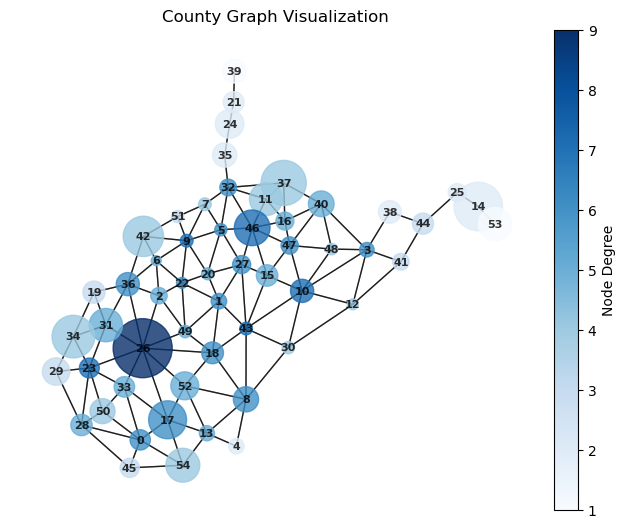

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 3191 rows, 3025 columns and 15070 nonzeros
Model fingerprint: 0x86628fcf
Variable types: 0 continuous, 3025 integer (3025 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+05]
  Objective range  [1e+06, 8e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 55 rows and 0 columns
Presolve time: 0.07s
Presolved: 3136 rows, 3025 columns, 15070 nonzeros
Variable types: 0 continuous, 3025 integer (3025 binary)
Found heuristic solution: objective 2.880980e+10
Found heuristic solution: objective 1.950776e+10

Root relaxation: objective 5.221255e+

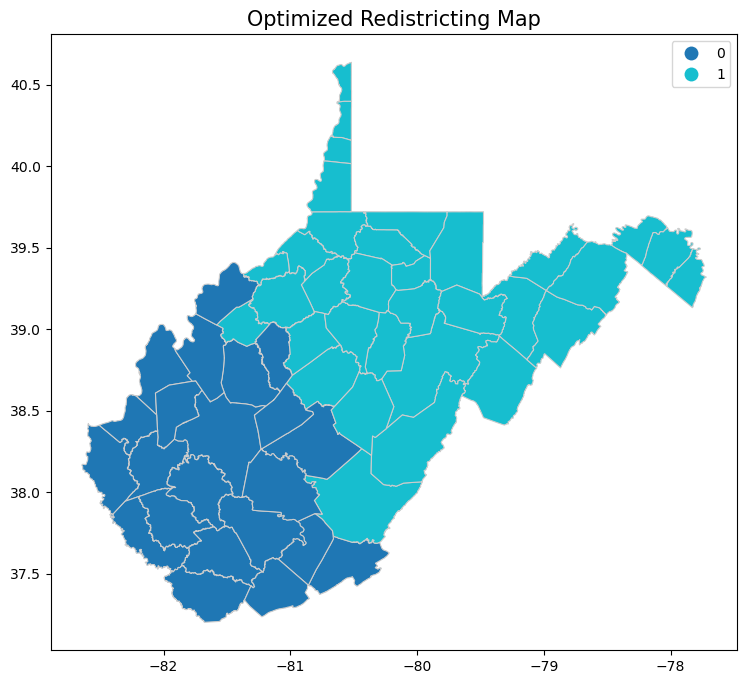

In [5]:
#Import necessary libraries
import geopandas as gpd
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
from geopy.distance import geodesic

from gerrychain import Graph

#-----------------------------------------------------------------------------------------
#                      READ THE DATA AND DISPLAY THE INFO
#-----------------------------------------------------------------------------------------
# read a county graph from a JSON file.
def read_county_graph(filename):
    return Graph.from_json(filename)

# Print information about counties (name, population, location)
def print_county_info(G, node):
    name = G.nodes[node]['NAME20']
    population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = population
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']
    print(f"Node {node} is {name} County, which has population {population} and is centered at ({G.nodes[node]['C_X']}, {G.nodes[node]['C_Y']})")

# calculate population bounds
# (based on a deviation parameter, total population, and the number of districts).
def calculate_population_bounds(G, deviation, k):
    total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)
    L = math.ceil((1 - deviation / 2) * total_population / k)
    U = math.floor((1 + deviation / 2) * total_population / k)
    return L, U

#create a dictionary of distances between each pair of nodes 
# based on their geographical locations.
def create_distance_dict(G):
    dist = {(i, j): 0 for i in G.nodes for j in G.nodes}
    for i in G.nodes:
        for j in G.nodes:
            loc_i = (G.nodes[i]['C_Y'], G.nodes[i]['C_X'])
            loc_j = (G.nodes[j]['C_Y'], G.nodes[j]['C_X'])
            dist[i, j] = geodesic(loc_i, loc_j).miles
    return dist

# Visualize the graph using networkx and matplotlib with enhanced styling
def visualize_graph(G):
    pos = {node: (float(G.nodes[node]['C_X']), float(G.nodes[node]['C_Y'])) for node in G.nodes}
    
    # Set node colors based on degree (you can customize this)
    node_colors = [G.degree(node) for node in G.nodes]
    
    # Set node size based on total population (you can customize this as well)
    node_size = [G.nodes[node]['TOTPOP'] / 100 for node in G.nodes]
    
    # Draw nodes with enhanced styling
    nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_colors, cmap=plt.cm.Blues, font_size=8, font_color="black", font_weight="bold", alpha=0.8)

    # Draw edges with reduced opacity
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    # Add a colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, ax=plt.gca()) 
    cbar.set_label('Node Degree')

    plt.title('County Graph Visualization')
    
    # Save the plot as a PNG file in the current working directory
    plt.savefig('county_graph.png')
    plt.show()

#-----------------------------------------------------------------------------------------
#                           OPTIMIZATION MODEL
#-----------------------------------------------------------------------------------------
# formulate and solve a mathematical optimization model
def optimize_partition(G, L, U, dist, k):
    m = gp.Model()

    # Variables
    X = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

    # Objective function
    m.setObjective(gp.quicksum(dist[i, j] * dist[i, j] * G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE)

    # Constraints
    m.addConstrs(gp.quicksum(X[i, j] for j in G.nodes) == 1 for i in G.nodes)
    m.addConstr(gp.quicksum(X[j, j] for j in G.nodes) == k)
    m.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes) >= L * X[j, j] for j in G.nodes)
    m.addConstrs(gp.quicksum(G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes) <= U * X[j, j] for j in G.nodes)
    m.addConstrs(X[i, j] <= X[j, j] for i in G.nodes for j in G.nodes)

    # Optimize
    m.Params.MIPGap = 0.0
    m.optimize()

    # Print result
    print("The moment of inertia objective is", m.objval)

    # Extract assignment results from the optimization model
    centers = [j for j in G.nodes if X[j, j].x > 0.5]
    
    # Assign nodes to districts based on decision variable values
    districts = [[i for i in G.nodes if X[i, j].x > 0.5] for j in centers]

    # Retrieve county names for each district
    district_counties = [[G.nodes[i]["NAME20"] for i in districts[j]] for j in range(k)]

    # Calculate total population for each district
    district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]
    
    # Print the assignment results
    for j in range(k):
        print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])

    return districts
#-----------------------------------------------------------------------------------------
#                    PLOT THE MAP WITH OPTIMIZED RESULTS
#-----------------------------------------------------------------------------------------
# plot the optimized redistricting map using the results
def plot_optimized_redistricting_map(G, districts, geo_df, geo_id_column, assignment_column):
    
    # Create a mapping of GEOID20 to node indices in the graph
    node_with_this_geoid = {G.nodes[i]['GEOID20']: i for i in G.nodes}
    
    # Initialize an assignment list with -1, representing unassigned nodes
    assignment = [-1 for _ in range(G.number_of_nodes())]

    # Assign each node to its corresponding district based on the optimization results
    for j, district in enumerate(districts):
        for i in district:
            assignment[node_with_this_geoid[G.nodes[i]['GEOID20']]] = j

    # Add the assignment column to the GeoDataFrame
    geo_df[assignment_column] = assignment

    # Plot the optimized redistricting map using GeoDataFrame
    fig, ax = plt.subplots(figsize=(12, 8))
    geo_df.plot(column=assignment_column, cmap='tab10', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, categorical=True)
    ax.set_title('Optimized Redistricting Map', fontdict={'fontsize': '15', 'fontweight': '3'})
    
    # Save the plot as a PNG file in the current working directory
    plt.savefig('final_district_map.png')
    plt.show()

#-----------------------------------------------------------------------------------------
#              APPLY THE MODEL CREATED ON A SPECIFIC CASE STUDY
#-----------------------------------------------------------------------------------------
# Apply the functions to a specific state
def main():
    
    # Path to the shapefile containing the geographical information of counties
    shapefile_path = r"C:\Users\Moise Baraka\OR-scrypts\West Virginia\WV_county.shp"
    
    # Read the shapefile into a GeoDataFrame
    df = gpd.read_file(shapefile_path)
    
    # Path to the JSON file containing the county graph data
    filename = r"C:\Users\Moise Baraka\OR-scrypts\West Virginia\WV_county.json"
    
    # Create a graph representation from the JSON file
    G = read_county_graph(filename)
    
    # Print information about each county in the graph
    for node in G.nodes:
        print_county_info(G, node)
        
    # Set the deviation and the number of desired districts
    deviation = 0.01
    k = 2       # number of districts
    
    # Calculate population bounds for each district
    L, U = calculate_population_bounds(G, deviation, k)
    print(f"Using L = {L}, U = {U}, and k = {k}")

    # Create a dictionary of distances between each pair of nodes 
    dist = create_distance_dict(G)

    # Visualize the original graph
    visualize_graph(G)

    # Optimize the partitioning of counties into districts
    districts = optimize_partition(G, L, U, dist, k)

    # Print the number of nodes in the graph and the DataFrame
    print("Number of nodes in G:", G.number_of_nodes())
    print("Number of nodes in DataFrame (df):", len(df))

    # Plot the optimized redistricting map
    plot_optimized_redistricting_map(G, districts, df, 'GEOID20', 'assignment')

if __name__ == "__main__":
    main()


# Type 2: Modeling with PySCIPopt
---

Node 0 is Wyoming County, which has population 21382 and is centered at (-081.5490317, +37.6036601)
Node 1 is Braxton County, which has population 12447 and is centered at (-080.7316597, +38.6993304)
Node 2 is Roane County, which has population 14028 and is centered at (-081.3544939, +38.7429497)
Node 3 is Grant County, which has population 10976 and is centered at (-079.1950640, +39.1059882)
Node 4 is Monroe County, which has population 12376 and is centered at (-080.5503295, +37.5540622)
Node 5 is Doddridge County, which has population 7808 and is centered at (-080.7114979, +39.2643068)
Node 6 is Wirt County, which has population 5194 and is centered at (-081.3829749, +39.0200337)
Node 7 is Tyler County, which has population 8313 and is centered at (-080.8772193, +39.4656340)
Node 8 is Greenbrier County, which has population 32977 and is centered at (-080.4505897, +37.9244177)
Node 9 is Ritchie County, which has population 8444 and is centered at (-081.0663167, +39.1771118)
Node 10 i

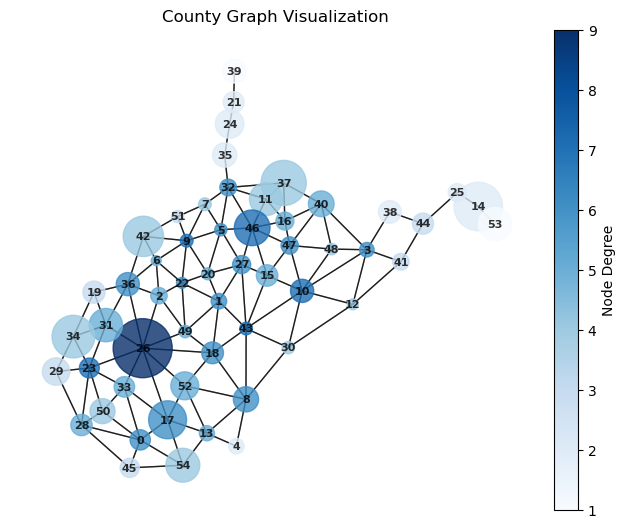

The moment of inertia objective is 2851722647.233473
District 0 has population 448156 and contains counties ['Wyoming', 'Braxton', 'Monroe', 'Greenbrier', 'Ritchie', 'Summers', 'Raleigh', 'Nicholas', 'Gilmer', 'Lincoln', 'Mingo', 'Pocahontas', 'Boone', 'Webster', 'McDowell', 'Clay', 'Logan', 'Fayette', 'Mercer']
District 1 has population 450212 and contains counties ['Roane', 'Wirt', 'Mason', 'Calhoun', 'Kanawha', 'Wayne', 'Putnam', 'Cabell', 'Jackson']
District 2 has population 449089 and contains counties ['Doddridge', 'Tyler', 'Marion', 'Upshur', 'Taylor', 'Brooke', 'Ohio', 'Lewis', 'Wetzel', 'Marshall', 'Hancock', 'Wood', 'Harrison', 'Barbour', 'Tucker', 'Pleasants']
District 3 has population 446259 and contains counties ['Grant', 'Randolph', 'Pendleton', 'Berkeley', 'Morgan', 'Monongalia', 'Mineral', 'Preston', 'Hardy', 'Hampshire', 'Jefferson']
Number of nodes in G: 55
Number of nodes in DataFrame (df): 55


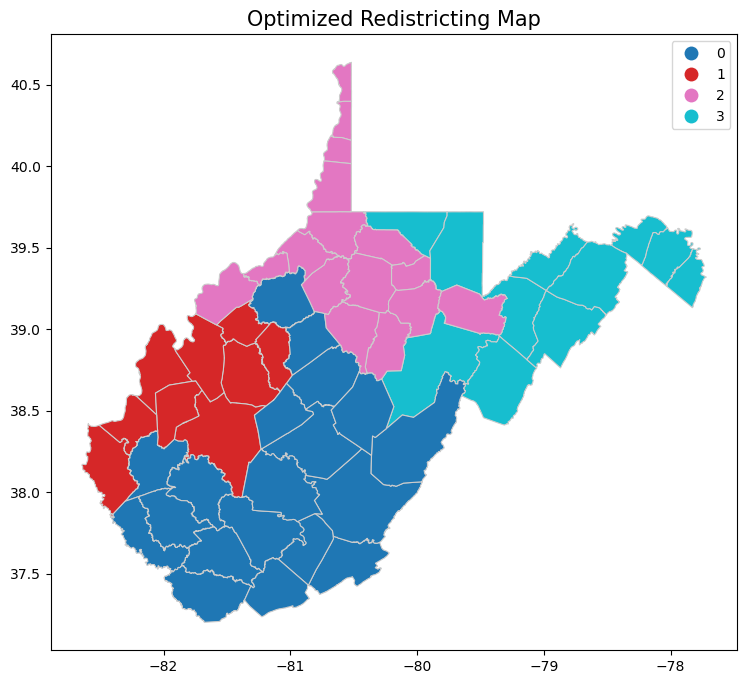

In [51]:
import geopandas as gpd
import networkx as nx
import pyscipopt as scip
import math
from geopy.distance import geodesic
import matplotlib.pyplot as plt

from gerrychain import Graph

# -----------------------------------------------------------------------------------------
#                           OPTIMIZATION MODEL
# -----------------------------------------------------------------------------------------
# formulate and solve a mathematical optimization model
def optimize_partition(G, L, U, dist, k):
    m = scip.Model()

    # Variables
    X = {}
    for i in G.nodes:
        for j in G.nodes:
            X[i, j] = m.addVar(vtype='B', name=f'X_{i}_{j}')

    # Objective function
    m.setObjective(
        scip.quicksum(dist[i, j] * dist[i, j] * G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes for j in G.nodes),
        "minimize"
    )

    # Constraints
    for i in G.nodes:
        m.addCons(scip.quicksum(X[i, j] for j in G.nodes) == 1)
    m.addCons(scip.quicksum(X[j, j] for j in G.nodes) == k)

    for j in G.nodes:
        m.addCons(scip.quicksum(G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes) >= L * X[j, j])
        m.addCons(scip.quicksum(G.nodes[i]['TOTPOP'] * X[i, j] for i in G.nodes) <= U * X[j, j])

    # Additional constraint to fix the issue
    for i in G.nodes:
        for j in G.nodes:
            m.addCons(X[i, j] <= X[j, j])

    # Optimize
    m.optimize()

    # Print result
    print("The moment of inertia objective is", m.getObjVal())

    # Extract assignment results from the optimization model
    centers = [j for j in G.nodes if m.getVal(X[j, j]) > 0.5]

    # Assign nodes to districts based on decision variable values
    districts = [[i for i in G.nodes if m.getVal(X[i, j]) > 0.5] for j in centers]

    # Retrieve county names for each district
    district_counties = [[G.nodes[i]["NAME20"] for i in districts[j]] for j in range(k)]

    # Calculate total population for each district
    district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]

    # Print the assignment results
    for j in range(k):
        print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])

    return districts

#-----------------------------------------------------------------------------------------
#              APPLY THE MODEL CREATED ON A SPECIFIC CASE STUDY
#-----------------------------------------------------------------------------------------
# Apply the functions to a specific state
def main():
    
    # Path to the shapefile containing the geographical information of counties
    shapefile_path = r"C:\Users\Moise Baraka\OR-scrypts\West Virginia\WV_county.shp"
    
    # Read the shapefile into a GeoDataFrame
    df = gpd.read_file(shapefile_path)
    
    # Path to the JSON file containing the county graph data
    filename = r"C:\Users\Moise Baraka\OR-scrypts\West Virginia\WV_county.json"
    
    # Create a graph representation from the JSON file
    G = read_county_graph(filename)
    
    # Print information about each county in the graph
    for node in G.nodes:
        print_county_info(G, node)
        
    # Set the user-defined inputs
    deviation = 0.01
    k = 2       # number of districts
    
    # Calculate population bounds for each district
    L, U = calculate_population_bounds(G, deviation, k)
    print(f"Using L = {L}, U = {U}, and k = {k}")

    # Create a dictionary of distances between each pair of nodes 
    dist = create_distance_dict(G)

    # Visualize the original graph
    visualize_graph(G)

    # Optimize the partitioning of counties into districts
    districts = optimize_partition(G, L, U, dist, k)

    # Print the number of nodes in the graph and the DataFrame
    print("Number of nodes in G:", G.number_of_nodes())
    print("Number of nodes in DataFrame (df):", len(df))

    # Plot the optimized redistricting map
    plot_optimized_redistricting_map(G, districts, df, 'GEOID20', 'assignment')

if __name__ == "__main__":
    main()
